In [35]:
import numpy as np
import pandas as pd
import json
from math import sqrt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from math import sqrt
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_1samp

In [2]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)

In [3]:
with open('config.json') as f:
    config = json.load(f)

data_path = config["data_path"]

ts = pd.read_csv(data_path)
ts = ts["Close"].values

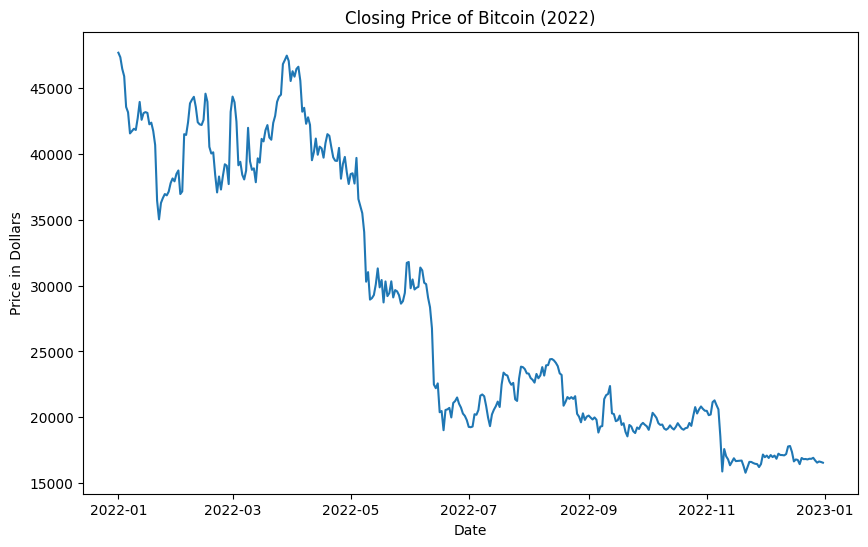

In [4]:
start_date = '2022-01-01'
end_date = '2022-12-31'
date_range = pd.date_range(start=start_date, end=end_date)

plt.figure(figsize=(10, 6))
plt.plot(date_range, ts)
plt.title('Closing Price of Bitcoin (2022)')
plt.xlabel('Date')
plt.ylabel('Price in Dollars')
plt.show()

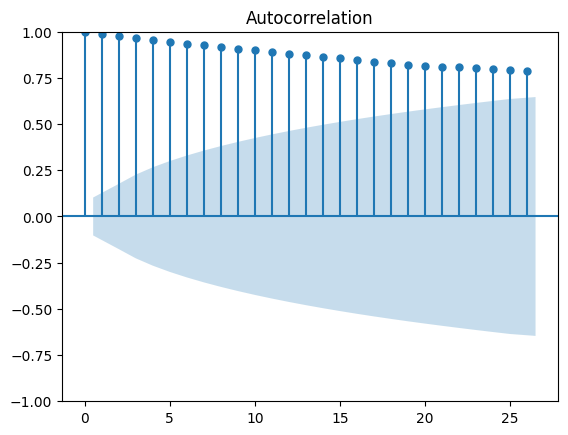

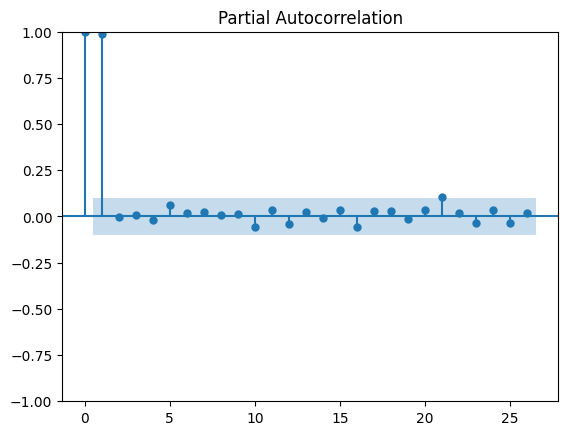

In [5]:
plot_acf(ts)
plt.show()

plot_pacf(ts)
plt.show()

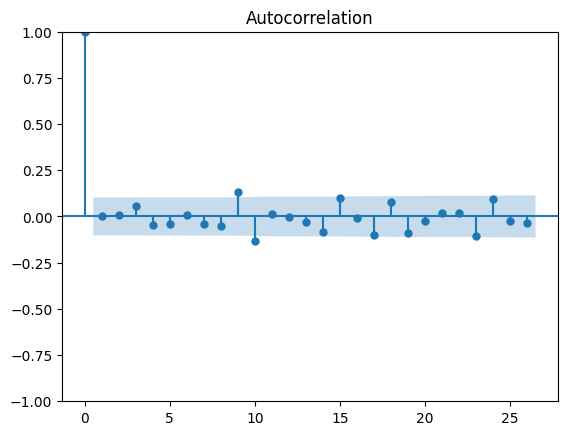

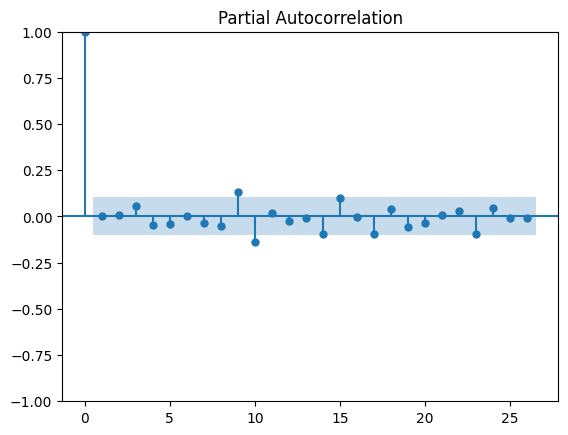

In [6]:
diff = np.diff(ts)

plot_acf(diff)
plt.show()

plot_pacf(diff)
plt.show()

In [7]:
unit_test = adfuller(diff)

#Print results
print('ADF Statistic: %f' % unit_test[0])
print('p-value: %f' % unit_test[1])
print('Critical Values:', unit_test[4])

if unit_test[1] <= 0.05:
    print(f'Reject the null hypothesis. The time-series is stationary.')
else: 
    print(f"Fail to reject the null hypothesis. The time-series is non-stationary")

ADF Statistic: -6.511663
p-value: 0.000000
Critical Values: {'1%': np.float64(-3.4489583388155194), '5%': np.float64(-2.869739378430086), '10%': np.float64(-2.5711381780459)}
Reject the null hypothesis. The time-series is stationary.


In [8]:
# train-validation-test split for time series
train_size = int(len(ts) * 0.70)
train, rest = ts[:train_size], ts[train_size:]

validation_size = int(len(rest) * 0.50)
validation, test = rest[:validation_size], rest[validation_size:]

print(len(train))
print(len(validation))
print(len(test))

255
55
55


In [9]:
lowest_aic = float('inf')
best_p_aic = None
best_q_aic = None

lowest_bic = float('inf')
best_p_bic = None
best_q_bic = None

for p in range(0,7):
    for q in range(0,7):
        #create model
        model=ARIMA(train, order=(p,1,q))
        results = model.fit()

        #AIC and BIC of model
        aic = results.aic
        bic = results.bic
        print(f"AR({p}), MA({q}), AIC: {aic}, BIC: {bic}")

        #Update the best order based on the lowest AIC
        if aic < lowest_aic:
            lowest_aic = aic
            best_p_aic = p
            best_q_aic = q
        
        #Update the best order based on the lowest BIC
        if bic < lowest_bic:
            lowest_bic = bic
            best_p_bic = p
            best_q_bic = q

print(f"\nBest ARIMA order based on AIC: ({best_p_aic},1,{best_q_aic}) \nBest ARIMA order based on BIC: ({best_p_bic},1,{best_q_bic})")

AR(0), MA(0), AIC: 4308.818418459345, BIC: 4312.355752726363
AR(0), MA(1), AIC: 4310.803344628967, BIC: 4317.878013163005
AR(0), MA(2), AIC: 4312.582955478284, BIC: 4323.1949582793395
AR(0), MA(3), AIC: 4314.543914370507, BIC: 4328.693251438581
AR(0), MA(4), AIC: 4312.793480790293, BIC: 4330.480152125386
AR(0), MA(5), AIC: 4314.473800275959, BIC: 4335.69780587807
AR(0), MA(6), AIC: 4315.183458348754, BIC: 4339.944798217884
AR(1), MA(0), AIC: 4310.80356557217, BIC: 4317.878234106207
AR(1), MA(1), AIC: 4312.8100688094255, BIC: 4323.422071610481
AR(1), MA(2), AIC: 4309.671561545709, BIC: 4323.820898613783
AR(1), MA(3), AIC: 4311.428335514823, BIC: 4329.1150068499155
AR(1), MA(4), AIC: 4312.733212391954, BIC: 4333.957217994065
AR(1), MA(5), AIC: 4313.4176956712545, BIC: 4338.179035540385
AR(1), MA(6), AIC: 4313.636603154768, BIC: 4341.935277290916
AR(2), MA(0), AIC: 4312.611716540454, BIC: 4323.223719341509
AR(2), MA(1), AIC: 4309.566612700624, BIC: 4323.715949768699
AR(2), MA(2), AIC: 431

In [ ]:
model = ARIMA(train, order=(best_p_aic,1,best_q_aic))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  255
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -2147.662
Date:                Wed, 11 Dec 2024   AIC                           4307.325
Time:                        13:50:17   BIC                           4328.549
Sample:                             0   HQIC                          4315.863
                                - 255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9230      0.028    -67.783      0.000      -1.979      -1.867
ar.L2         -0.9249      0.028    -32.806      0.000      -0.980      -0.870
ma.L1          1.9554      0.077     25.526      0.0

Residual Diagnostics:

The mean of the residuals is not statistically significant from zero

Breusch-Pagan Test:
Lagrange multiplier statistic: 2.3439
p-value: 0.3098
f-value: 1.1689
f p-value: 0.3124

White's Test:
Test Statistic: 2.5649
p-value: 0.7667
f-value: 0.5059
f p-value: 0.7717

No significant autocorrelation detected in the residuals.


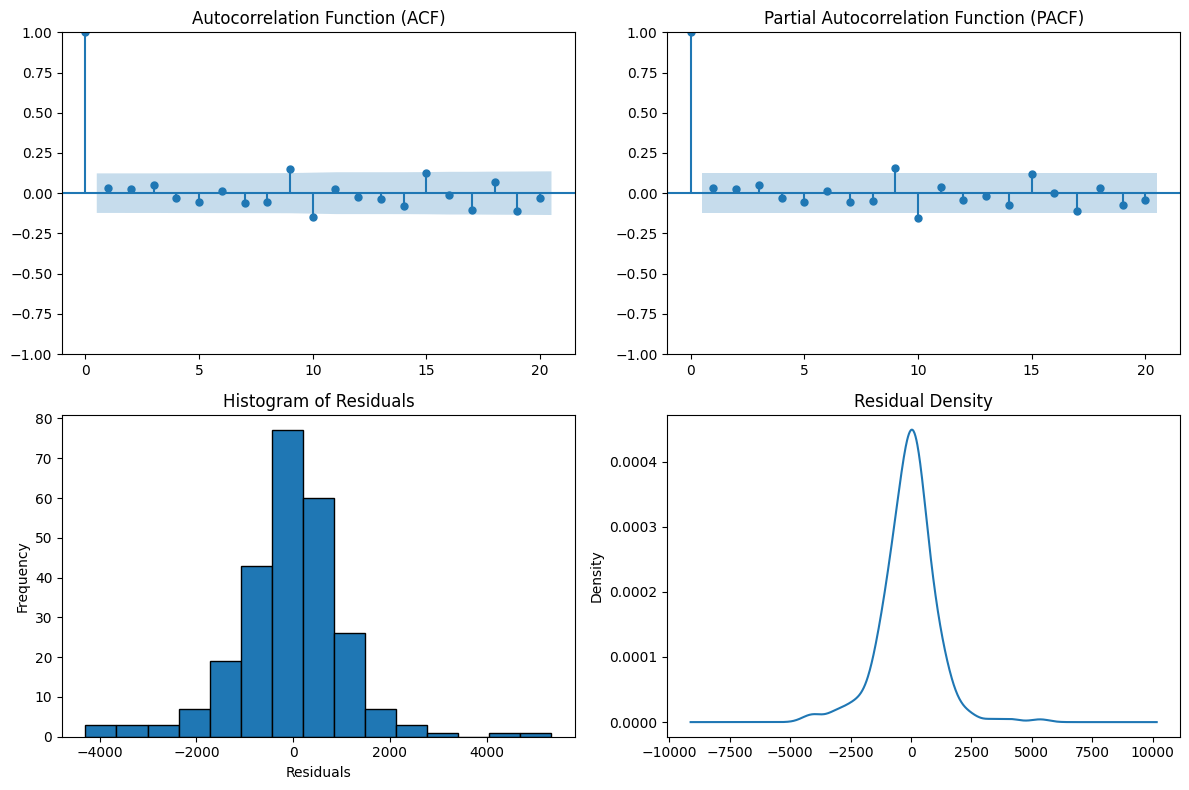

In [11]:
residuals = results.resid[1:]

def residual_diagnostics(residuals):

    residuals = pd.Series(residuals)

    print("Residual Diagnostics:\n")

    # 1. Test for the expected value of the residuals. We would expect them to be = 0
    t_stat, p_value = ttest_1samp(residuals,0)
    if p_value < 0.05:
        print('The mean of the residuals is statistically different from zero\n')
    else:
        print('The mean of the residuals is not statistically significant from zero\n')

    # 2. Test for linear and non-linear heteroscedasticity
    lags = sm.add_constant(
    pd.DataFrame({
        f"lag_{i}": residuals.shift(i) for i in range(1, 3)  # Using 2 lags as an example
    }).dropna()
)

    # Breusch-Pagan test
    bp_test = het_breuschpagan(residuals[lags.index], lags)
    bp_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
    bp_results = dict(zip(bp_labels, bp_test))

    # White's test
    white_test = het_white(residuals[lags.index], lags)
    white_labels = ['Test Statistic', 'p-value', 'f-value', 'f p-value']
    white_results = dict(zip(white_labels, white_test))

    # Display results
    print("Breusch-Pagan Test:")
    for k, v in bp_results.items():
        print(f"{k}: {v:.4f}")

    print("\nWhite's Test:")
    for k, v in white_results.items():
        print(f"{k}: {v:.4f}")

    # 3. Test for residual serial correlation (Breusch-Godfrey test)
    X = sm.add_constant(np.arange(len(residuals)))
    reg_model = sm.OLS(residuals, X).fit()
    bg_test = acorr_breusch_godfrey(reg_model, nlags=4)
    if bg_test[1] < 0.05:
        print("\nSignificant autocorrelation detected in the residuals.")
    else:
        print("\nNo significant autocorrelation detected in the residuals.")
    
    # 4. Plot Residual Diagnostics
    plt.figure(figsize=(12, 8))
    
    # Plot ACF
    plt.subplot(2, 2, 1)
    plot_acf(residuals, lags=20, ax=plt.gca())
    plt.title("Autocorrelation Function (ACF)")
    
    # Plot PACF
    plt.subplot(2, 2, 2)
    plot_pacf(residuals, lags=20, ax=plt.gca(), method='ywm')
    plt.title("Partial Autocorrelation Function (PACF)")
    
    # Histogram of residuals
    plt.subplot(2, 2, 3)
    plt.hist(residuals, bins=15, edgecolor='k')
    plt.title("Histogram of Residuals")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    
    # QQ Plot
    plt.subplot(2, 2, 4)
    pd.Series(residuals).plot(kind='kde')
    plt.title("Residual Density")
    
    plt.tight_layout()
    plt.show()

# Perform diagnostics
residual_diagnostics(residuals)

In [ ]:
train_predictions = results.fittedvalues[1:] #remove the first value due to differencing in ARIMA

train_mse = mean_squared_error(train[1:], train_predictions)
train_rmse = sqrt(train_mse)
print(f"Train RMSE: {train_rmse}")

Train RMSE: 1137.5035945158836


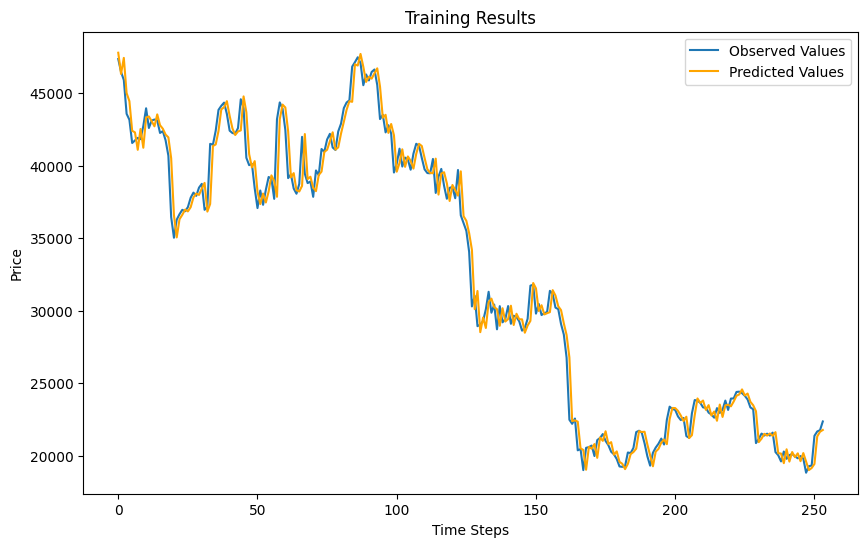

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train[1:], label='Observed Values')
plt.plot(train_predictions, c='orange', label="Predicted Values")
plt.title("Training Results")
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

## Validation

In [14]:
def validiation_process(train_set, validation_set):
    '''
    Selects the most optimal model parameters based on RMSE on the validation set. 

    Input: training set, validation set
    Output: optimal p, optimal q, rmse, predictions
    '''

    #These are the values to be returned by this function
    best_p = None
    best_q = None
    lowest_rmse = float('inf')
    predictions = []

    #Run through each possible p and q in our selected range
    for p in range(0,7):
        for q in range(0,7):
            try:
                history = list(train_set)
                temp_predictions = [] 

                #Run through each valdiation set observation
                for i in range(len(validation_set)):
                    model = ARIMA(history, order=(p,1,q))
                    results = model.fit()
                    
                    #One-step-ahead forecast
                    yhat = results.forecast()
                    yhat = yhat[0]

                    #Append history with latest observation and update predictions with latest prediction
                    obs = validation_set[i]
                    history.append(obs)
                    temp_predictions.append(yhat)
                
                #Calculate RMSE for the predictions 
                valid_mse = mean_squared_error(validation_set, temp_predictions)
                valid_rmse = sqrt(valid_mse)
                print(f"Validation RMSE for ARIMA({p},1,{q}): {valid_rmse}")

                #Update optimal ARMA model based on RMSE and update its predictions
                if valid_rmse < lowest_rmse:
                    best_p = p
                    best_q = q
                    lowest_rmse = valid_rmse
                    predictions = temp_predictions
                    print(f"New best p and q: {best_p}, {best_q}")

            except Exception as e:
                print(f'Skipped ARIMA({p},1,{q}) due to: {e}')
            
    return best_p, best_q, lowest_rmse, predictions

best_p_valid, best_q_valid, lowest_rmse_valid, valid_predictions = validiation_process(train, validation)

Validation RMSE for ARIMA(0,1,0): 455.7578096902514
New best p and q: 0, 0
Validation RMSE for ARIMA(0,1,1): 455.5360213017831
New best p and q: 0, 1
Validation RMSE for ARIMA(0,1,2): 454.73504585694536
New best p and q: 0, 2
Validation RMSE for ARIMA(0,1,3): 454.9063153790765
Validation RMSE for ARIMA(0,1,4): 439.6526597230183
New best p and q: 0, 4
Validation RMSE for ARIMA(0,1,5): 440.94339170343443
Validation RMSE for ARIMA(0,1,6): 437.35418134612695
New best p and q: 0, 6
Validation RMSE for ARIMA(1,1,0): 455.54391135607386
Validation RMSE for ARIMA(1,1,1): 455.49904975001334
Validation RMSE for ARIMA(1,1,2): 444.9749578257968
Validation RMSE for ARIMA(1,1,3): 444.9120887631991
Validation RMSE for ARIMA(1,1,4): 441.0334026765303
Validation RMSE for ARIMA(1,1,5): 435.92808276733615
New best p and q: 1, 5
Validation RMSE for ARIMA(1,1,6): 437.93300230943163
Validation RMSE for ARIMA(2,1,0): 454.8923401865999
Validation RMSE for ARIMA(2,1,1): 446.9741542452491
Validation RMSE for ARI

Optimal ARIMA Model: ARIMA(6,1,2)
Validation RMSE: 435.37320756627594


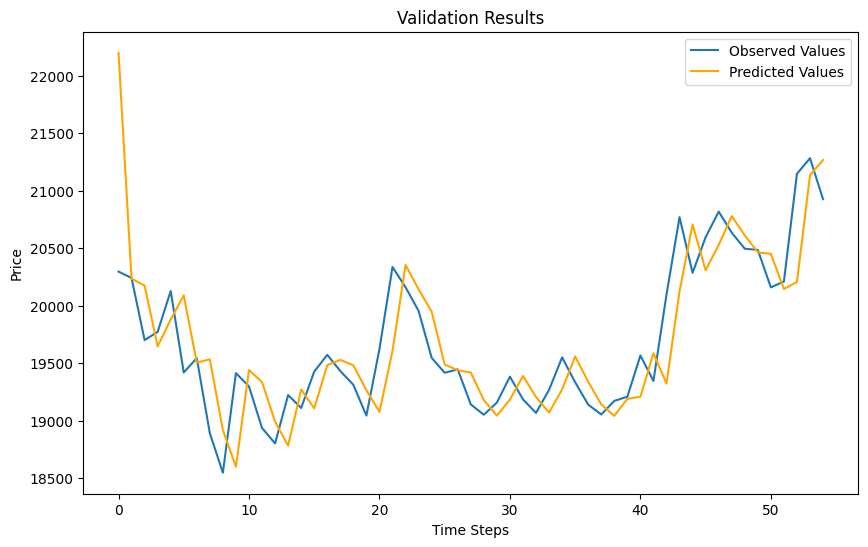

In [15]:
print(f'Optimal ARIMA Model: ARIMA({best_p_valid},1,{best_q_valid})')
print(f'Validation RMSE: {lowest_rmse_valid}')

plt.figure(figsize=(10, 6))
plt.plot(validation, label='Observed Values')
plt.plot(valid_predictions, c='orange', label="Predicted Values")
plt.title("Validation Results")
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

Residual Diagnostics:

The mean of the residuals is not statistically significant from zero

Breusch-Pagan Test:
Lagrange multiplier statistic: 2.4151
p-value: 0.2989
f-value: 1.1936
f p-value: 0.3116

White's Test:
Test Statistic: 2.6095
p-value: 0.7599
f-value: 0.4868
f p-value: 0.7844

No significant autocorrelation detected in the residuals.


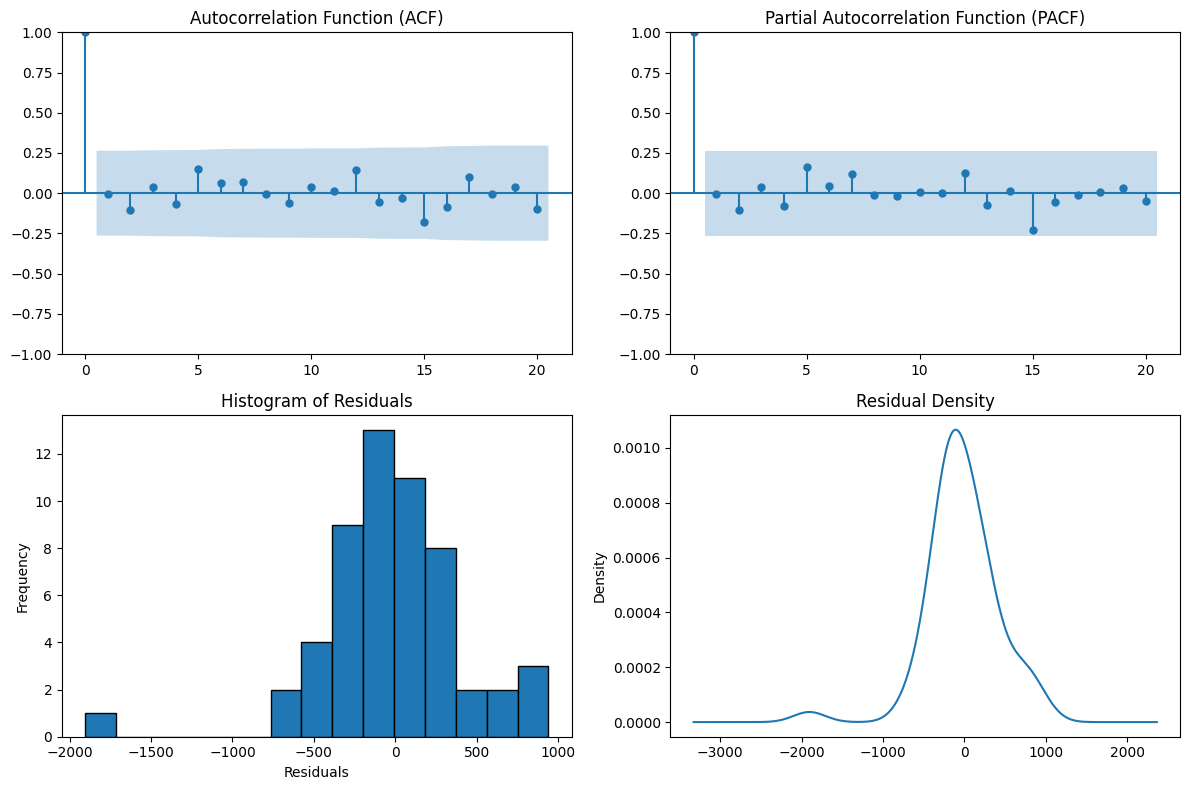

In [16]:
# plot residuals
residuals_valid = validation - valid_predictions
residual_diagnostics(residuals_valid)


## Testing

Test RMSE: 584.1585623248634


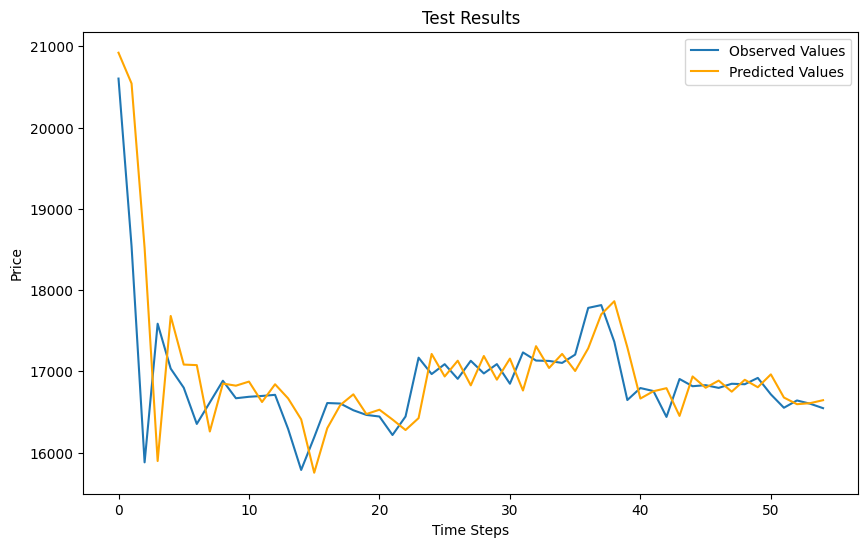

In [17]:
def testing_process(training_set, validation_set, testing_set, p, q):
    '''
    Makes out-of-sample predictions on the testing set.

    Input: train, validation, and testing set, optimal p and q based on validation testing
    Output: predictions, rmse
    '''

    history = list(training_set) + list(validation_set)
    predictions = []

    #Prediction
    for i in range(len(testing_set)):
        model = ARIMA(history, order=(p,1,q))
        results = model.fit()
        
        #One-step-ahead forecast
        yhat = results.forecast()
        yhat = yhat[0]

        #Append history with latest observation and update predictions with latest prediction
        obs = testing_set[i]
        history.append(obs)
        predictions.append(yhat)
    
    #Calculate RMSE
    mse = mean_squared_error(testing_set, predictions)
    rmse = sqrt(mse)
            
    return predictions, rmse

test_predictions, test_rmse = testing_process(train, validation, test, best_p_valid, best_q_valid)

print(f'Test RMSE: {test_rmse}')

plt.figure(figsize=(10, 6))
plt.plot(test, label='Observed Values')
plt.plot(test_predictions, c='orange', label="Predicted Values")
plt.title("Test Results")
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

Residual Diagnostics:

The mean of the residuals is not statistically significant from zero

Breusch-Pagan Test:
Lagrange multiplier statistic: 25.4085
p-value: 0.0000
f-value: 23.0221
f p-value: 0.0000

White's Test:
Test Statistic: 49.2907
p-value: 0.0000
f-value: 124.9116
f p-value: 0.0000

No significant autocorrelation detected in the residuals.


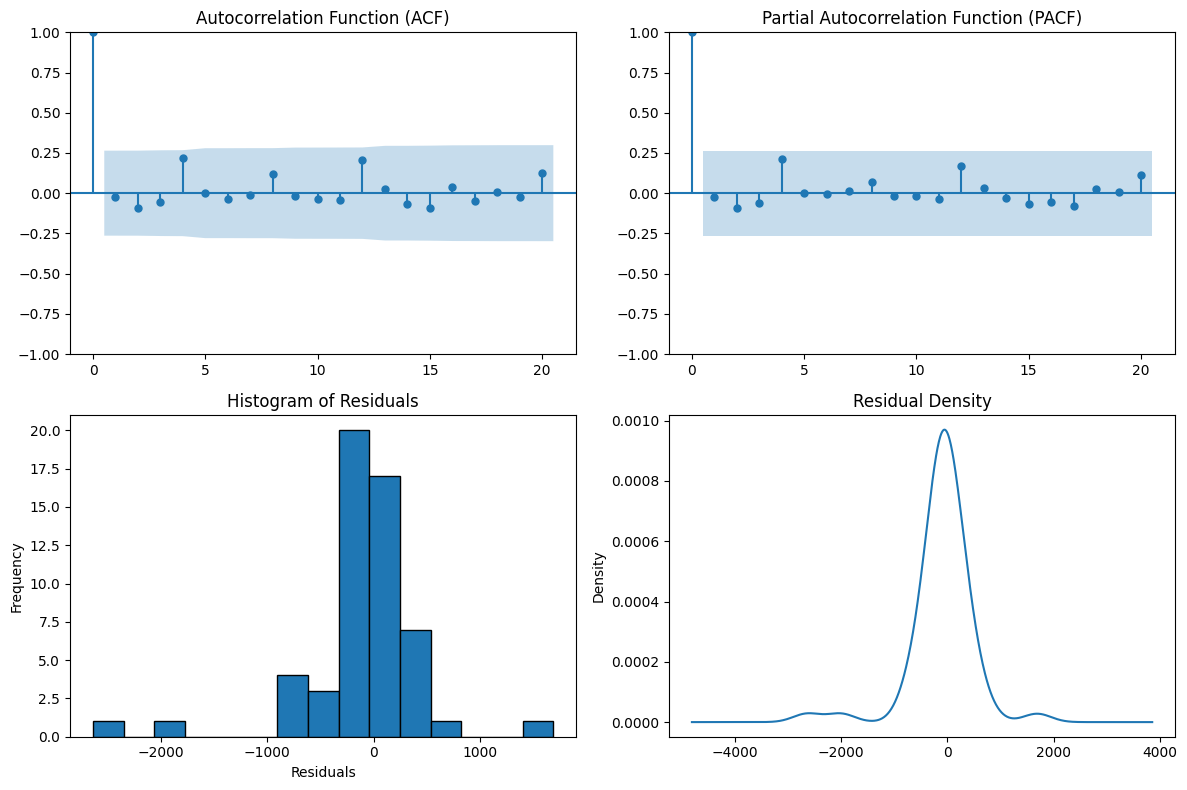

In [18]:
# plot residuals
residuals_test = test - test_predictions
residual_diagnostics(residuals_test)

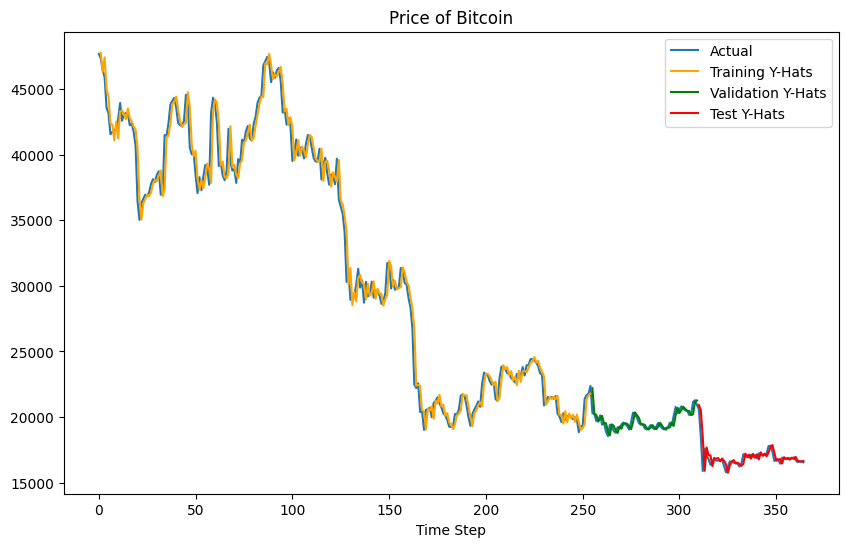

In [ ]:
train_plot = np.ones_like(ts) * np.nan
train_plot[1:train_size] = train_predictions

valid_plot = np.ones_like(ts) * np.nan
valid_plot[train_size:train_size+validation_size] = valid_predictions

test_plot = np.ones_like(ts) * np.nan
test_plot[train_size+validation_size:] = test_predictions

# plot
plt.figure(figsize=(10, 6))
plt.plot(ts, label='Actual')
plt.plot(train_plot, c='orange', label="Training Y-Hats")
plt.plot(valid_plot, c='green', label='Validation Y-Hats')
plt.plot(test_plot, c='r', label='Test Y-Hats')
plt.xlabel('Time Step')
plt.title('Price of Bitcoin')
plt.legend()
plt.show()